In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import itertools

from matplotlib.gridspec import GridSpec
from tensorflow.keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences


dataset_dir = 'sentiment140'
# dataset_dir = 'imdb'
# dataset_dir = 'coronaNLP'

# vaccines = ["biontech", "janssen", "moderna",
#             "oxford", "sinopharm", "sinovac", "sputnik"]



# years = ["2020", "2021", "2022"]
# months = ["january", "february", "march", "april", "may", "june",
#           "july", "august", "september", "october", "november", "december"]
# models_dir = '../models/NN_model_seven_12008898266757515530_0.7899888157844543'
# tokenizers_dir = '../tokenizers/12008898266757515530.pkl'
# model = load_model(models_dir)
# model.summary()
# tokenizer = joblib.load(tokenizers_dir)
# word_index = tokenizer.word_index
# for year in years:
#     for month in months:
#         
#         

#         # already processed
#         try:
#             df = pd.read_csv(f'../{year}-data/covid-{month}.csv', delimiter=',')
#         except Exception:
#             continue

#         df = df.drop_duplicates()

#         df = df[['tweet', 'sentiment']]

#         df.head()
#         
#         
#         
#         

#         X = df.iloc[:, 0].fillna(' ')

#         tweets = X

#         num_of_tweets_analyzed = len(tweets)

#         sequences = tokenizer.texts_to_sequences(X)


#         # Max number of words in a sequence
#         max_length = 37

#         padded = pad_sequences(
#             sequences, maxlen=max_length, padding="post", truncating="post")

#         # Check reversing the indices

#         # flip (key, value)
#         reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

#         def decode(sequence):
#             return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

#         predictions = model.predict(padded)

#         # Only for BinaryCrossentropy
#         predictions = [1 if p > 0.5 else 0 for p in predictions]

#         # saving tweets to csv
#         tweets.to_csv(f'../analysis/tweets-{month}-{year}.csv')
#         # saving sentiment predictions to csv
#         np.savetxt(f'../analysis/predictions-{month}-{year}.csv',
#                    predictions, delimiter=',', fmt=('%s'))

#         # adding sentiment column to the beginning
#         df = pd.read_csv(
#             f'../analysis/predictions-{month}-{year}.csv', header=None)
#         df.rename(columns={0: 'sentiment'}, inplace=True)
#         # save to new csv file
#         df.to_csv(
#              f'../analysis/predictions-{month}-{year}.csv', index=False)

#         # merging tweets and predictions
#         filenames = [f'../analysis/tweets-{month}-{year}.csv',
#                        f'../analysis/predictions-{month}-{year}.csv']
#         dfs = []
#         for filename in filenames:
#             # read the csv, making sure the first two columns are str
#             df = pd.read_csv(filename, header=None,
#                              converters={0: str, 1: str})
#             # change the column names so they won't collide during concatenation
#             df.columns = [filename + str(cname) for cname in df.columns]
#             dfs.append(df)

#         # concatenate them horizontally
#         merged = pd.concat(dfs, axis=1)
#         # write it out
#         merged.to_csv(
#             f"../analysis/merged-{month}-{year}.csv", header=None, index=None)

#         df = pd.read_csv(f'../analysis/merged-{month}-{year}.csv')

#         labels = ['negative', 'positive']

#         title_type = df.groupby('sentiment').agg('count')

#         type_labels = ['positive', 'negative']
#         type_counts = title_type.tweet.sort_values()

#         colors = ['g', 'r']

#         plt.subplot(
#             aspect=1, title=f'Percentage of tweets pro or against vaccination in {month.capitalize()} {year}\nClassified {num_of_tweets_analyzed} tweets.')
#         type_show_ids = plt.pie(type_counts, labels=type_labels,
#                                 autopct='%1.1f%%', shadow=True, colors=colors)
#         plt.savefig(f"../visuals/{month}-{year}.png")



war = []

for file in os.listdir("../data/"):
    war.append(file)
    

models_dir = '../models/NN_model_seven_12008898266757515530_0.7899888157844543'
tokenizers_dir = '../tokenizers/12008898266757515530.pkl'
model = load_model(models_dir)
model.summary()
tokenizer = joblib.load(tokenizers_dir)
word_index = tokenizer.word_index


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddinglayer (Embedding)  (None, 37, 64)            3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 37, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,251,777
Trainable params: 3,251,777
Non-

war-czech.csv
                                               tweet  sentiment
0  Martin arrive after returning from Ukraine thi...          2
1  SIK99 is Taki stupid most of today's Ukrainian...          2
2  If Russia stops fighting the war will end the ...          2
3  Listi I have understood the argumentation of d...          2
4  Blog e Fiala Another great thing is how Putin ...          2
war-french.csv
                                               tweet  sentiment
0  Biden sends Venezuela to obtain oil president ...          2
1  To believe that Lukrain leads by procur a war ...          2
2  Direct - Guerr in Ukrain read increases his ai...          2
3  On February 24, Vladimir Poutin lacs a contain...          2
4  This is what the Westerners want to push Russi...          2
war-german.csv
                                               tweet  sentiment
0  83 RUS Russia un Ulyanov osc eu Mitru 2⃣ The U...          2
1  The error is marked yellow voelkerrecht un Cha...        

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000002633DB35438>


                                               tweet  sentiment
0  Is not a war profit we sell Ingent to Russia a...          2
1  Ukraine has moved the court of European democr...          2
2  I see full of those around the world know some...          2
3  Doria Russia Soviet has just fine invades coun...          2
4  Red does not know what a safety guarantee is t...          2
war-polish.csv


TypeError: object NoneType can't be used in 'await' expression

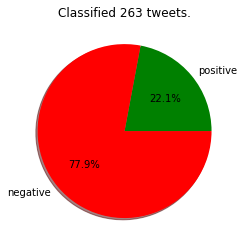

In [21]:

import async_google_trans_new
import asyncio


async def main():
    g = async_google_trans_new.AsyncTranslator()
    for lang in war:
        print(lang)
        # already processed
        df = pd.read_csv(f'../data/{lang}', delimiter=',')
        df = df.drop_duplicates()
        df = df[['tweet', 'sentiment']]
        async def translate(text):
            if text is not None:
                return await g.translate(text, "en")
            return " "
        
        # df['tweet'] = df['tweet'].apply(translate)
        df['tweet'] = await asyncio.gather(*[translate(text) for text in df['tweet']])
        print(df.head())

        X = df.iloc[:, 0].fillna(' ')

        tweets = X

        num_of_tweets_analyzed = len(tweets)

        sequences = tokenizer.texts_to_sequences(X)

        # Max number of words in a sequence
        max_length = 37

        padded = pad_sequences(
            sequences, maxlen=max_length, padding="post", truncating="post")

        # Check reversing the indices

        # flip (key, value)
        reverse_word_index = dict([(idx, word)
                                    for (word, idx) in word_index.items()])

        def decode(sequence):
            return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

        predictions = model.predict(padded)
        
        # Only for BinaryCrossentropy
        predictions = [1 if p > 0.5 else 0 for p in predictions]
        
        # saving tweets to csv
        tweets.to_csv(f'../analysis/tweets-{lang}.csv')
        # saving sentiment predictions to csv
        np.savetxt(f'../analysis/predictions-{lang}.csv',
                predictions, delimiter=',', fmt=('%s'))
        # adding sentiment column to the beginning
        df = pd.read_csv(
            f'../analysis/predictions-{lang}.csv', header=None)
        df.rename(columns={0: 'sentiment'}, inplace=True)
        # save to new csv file
        df.to_csv(
            f'../analysis/predictions-{lang}.csv', index=False)
        # merging tweets and predictions
        filenames = [f'../analysis/tweets-{lang}.csv',
                    f'../analysis/predictions-{lang}.csv']
        dfs = []
        for filename in filenames:
            # read the csv, making sure the first two columns are str
            df = pd.read_csv(filename, header=None,
                            converters={0: str, 1: str})
            # change the column names so they won't collide during concatenation
            df.columns = [filename + str(cname) for cname in df.columns]
            dfs.append(df)
        # concatenate them horizontally
        merged = pd.concat(dfs, axis=1)
        # write it out
        merged.to_csv(
            f"../analysis/merged-{lang}.csv", header=None, index=None)
        df = pd.read_csv(f'../analysis/merged-{lang}.csv')
        title_type = df.groupby('sentiment').agg('count')
        type_labels = ['positive', 'negative']
        type_counts = title_type.tweet.sort_values()
        colors = ['g', 'r']
        plt.subplot(
            aspect=1, title=f'Classified {num_of_tweets_analyzed} tweets.')
        type_show_ids = plt.pie(type_counts, labels=type_labels,
                                autopct='%1.1f%%', shadow=True, colors=colors)
        plt.savefig(f"../visuals/{lang}.png")
    
await main()


In [ ]:

# models_dir = '../models/NN_model_seven_12008898266757515530_0.7899888157844543'
# tokenizers_dir = '../tokenizers/12008898266757515530.pkl'
# model = load_model(models_dir)
# model.summary()
# tokenizer = joblib.load(tokenizers_dir)
# word_index = tokenizer.word_index
# for vaccine in vaccines:
#     
#     
#     # already processed
#     df = pd.read_csv(f'../vaccines/{vaccine}.csv', delimiter=',')
#     df = df.drop_duplicates()
#     df = df[['tweet', 'sentiment']]
#     
#     
#     
#     

#     X = df.iloc[:, 0].fillna(' ')

#     tweets = X

#     num_of_tweets_analyzed = len(tweets)

#     sequences = tokenizer.texts_to_sequences(X)

#     # Max number of words in a sequence
#     max_length = 37

#     padded = pad_sequences(
#           sequences, maxlen=max_length, padding="post", truncating="post")

#     # Check reversing the indices

#     # flip (key, value)
#     reverse_word_index = dict([(idx, word)
#                                   for (word, idx) in word_index.items()])

#     def decode(sequence):
#         return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

#     predictions = model.predict(padded)

#     # Only for BinaryCrossentropy
#     predictions = [1 if p > 0.5 else 0 for p in predictions]
#     # saving tweets to csv
#     tweets.to_csv(f'../analysis/tweets-{vaccine}.csv')
#     # saving sentiment predictions to csv
#     np.savetxt(f'../analysis/predictions-{vaccine}.csv',
#                predictions, delimiter=',', fmt=('%s'))
#     # adding sentiment column to the beginning
#     df = pd.read_csv(
#         f'../analysis/predictions-{vaccine}.csv', header=None)
#     df.rename(columns={0: 'sentiment'}, inplace=True)
#     # save to new csv file
#     df.to_csv(
#          f'../analysis/predictions-{vaccine}.csv', index=False)
#     # merging tweets and predictions
#     filenames = [f'../analysis/tweets-{vaccine}.csv',
#                    f'../analysis/predictions-{vaccine}.csv']
#     dfs = []
#     for filename in filenames:
#         # read the csv, making sure the first two columns are str
#         df = pd.read_csv(filename, header=None,
#                          converters={0: str, 1: str})
#         # change the column names so they won't collide during concatenation
#         df.columns = [filename + str(cname) for cname in df.columns]
#         dfs.append(df)
#     # concatenate them horizontally
#     merged = pd.concat(dfs, axis=1)
#     # write it out
#     merged.to_csv(
#         f"../analysis/merged-{vaccine}.csv", header=None, index=None)
#     df = pd.read_csv(f'../analysis/merged-{vaccine}.csv')
#     labels = ['negative', 'positive']
#     title_type = df.groupby('sentiment').agg('count')
#     type_labels = ['positive', 'negative']
#     type_counts = title_type.tweet.sort_values()
#     colors = ['g', 'r']
#     plt.subplot(
#         aspect=1, title=f'Percentage of tweets pro or against vaccination in {month.capitalize()} {year}\nClassified {num_of_tweets_analyzed} tweets.')
#     type_show_ids = plt.pie(type_counts, labels=type_labels,
#                             autopct='%1.1f%%', shadow=True, colors=colors)
#     plt.savefig(f"../visuals/{vaccine}.png")